In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

# I. Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

### Acquire Data:

In [98]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = env.get_db_url('logs')
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [87]:
for col in df.columns:
    print(df.value_counts(col))
    print('\n-----\n')

ip
97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
52.87.230.102         2
70.121.214.34         2
35.175.171.137        2
54.145.52.184         1
54.172.14.223         1
3.88.129.158          1
52.91.30.150          1
3.92.201.136          1
45.23.250.16          1
35.174.209.2          1
34.229.70.250         1
34.207.64.242         1
52.90.165.200         1
dtype: int64

-----

timestamp
16/Apr/2019 19:56:10    9
16/Apr/2019 19:49:58    8
16/Apr/2019 20:01:30    7
16/Apr/2019 20:12:23    6
16/Apr/2019 20:02:59    6
                       ..
16/Apr/2019 21:10:09    1
16/Apr/2019 21:10:07    1
16/Apr/2019 21:10:05    1
16/Apr/2019 21:10:03    1
17/Apr/2019 12:55:14    1
Length: 9953, dtype: int64

-----

request_method
GET    13974
dtype: int64

-----

request_path
/api/v1/sales?page=2                       709
/api/v1/items                              464
/api/v1/items?page=2             

### From Value Counts, next steps:
1. Examine Dataframe with tail of IP address count (all IP addresses < 3 to start)
2. Histogram timestamp and look for weird stuff
3. Examine Dataframe with tail of request paths
4. Examine all non 200 status codes
5. Sort by size to identify anything huge
6. Histogram of sizes
7. Think more about user_agent

### 1. Examine Dataframe with tail of IP address count (all IP addresses < 3 to start)

In [88]:
indexer = df.value_counts('ip')[df.value_counts('ip') < 3].index

In [95]:
low_ip_count = df.ip.isin(indexer)

In [97]:
df[low_ip_count]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
223,3.92.201.136,16/Apr/2019 19:39:14,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
224,52.90.165.200,16/Apr/2019 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
318,3.88.129.158,16/Apr/2019 19:40:32,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...
320,34.207.64.242,16/Apr/2019 19:40:33,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
324,54.172.14.223,16/Apr/2019 19:40:36,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...
325,34.229.70.250,16/Apr/2019 19:40:37,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
7828,35.175.171.137,16/Apr/2019 21:22:22,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
7829,54.145.52.184,16/Apr/2019 21:22:22,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
7831,52.87.230.102,16/Apr/2019 21:22:23,GET,/api/v1/sales,HTTP/1.1,200,493905,Slackbot-LinkExpanding 1.0 (+https://api.slack...
8827,35.175.171.137,16/Apr/2019 21:38:57,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...


Most of these seem to be slackbot related.  All are 200.  There is the one huge sized file though of sales which doesn't seem to make sense - did they somehow download all pages at once?

Let's look at the two IPs with 21 GETs each:

In [100]:
df[df.ip == '68.201.219.223']

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
11964,68.201.219.223,17/Apr/2019 01:29:13,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
11965,68.201.219.223,17/Apr/2019 01:29:15,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0
11991,68.201.219.223,17/Apr/2019 01:40:25,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
11999,68.201.219.223,17/Apr/2019 01:40:43,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
12305,68.201.219.223,17/Apr/2019 01:58:47,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
12307,68.201.219.223,17/Apr/2019 01:58:48,GET,/api/v1/items/api/v1/items?page=2,HTTP/1.1,200,162,python-requests/2.21.0
12308,68.201.219.223,17/Apr/2019 01:58:48,GET,/api/v1/items/api/v1/items?page=3,HTTP/1.1,200,162,python-requests/2.21.0
12318,68.201.219.223,17/Apr/2019 01:59:16,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
12325,68.201.219.223,17/Apr/2019 01:59:32,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
12331,68.201.219.223,17/Apr/2019 01:59:51,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0


Some strange empty request paths here.

In [102]:
df[df.ip == '24.26.242.9']

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
13882,24.26.242.9,17/Apr/2019 05:50:21,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
13883,24.26.242.9,17/Apr/2019 05:50:21,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0
13884,24.26.242.9,17/Apr/2019 05:50:22,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0
13885,24.26.242.9,17/Apr/2019 05:53:32,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
13886,24.26.242.9,17/Apr/2019 05:53:32,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0
13887,24.26.242.9,17/Apr/2019 05:53:33,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0
13888,24.26.242.9,17/Apr/2019 06:11:01,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
13889,24.26.242.9,17/Apr/2019 06:11:01,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0
13890,24.26.242.9,17/Apr/2019 06:11:03,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0
13891,24.26.242.9,17/Apr/2019 06:12:20,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0


Some more big downloads here.

### 2. Histogram timestamp and look for weird stuff

In [103]:
# convert our date column to datetime type
df.timestamp = pd.to_datetime(df.timestamp)
df.dtypes

ip                        object
timestamp         datetime64[ns]
request_method            object
request_path              object
http_version              object
status_code               object
size                       int64
user_agent                object
dtype: object

In [109]:
df.timestamp.min(), df.timestamp.max()

(Timestamp('2019-04-16 19:34:42'), Timestamp('2019-04-17 12:55:14'))

In [116]:
df = df.set_index('timestamp').sort_index()
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


<AxesSubplot:xlabel='timestamp'>

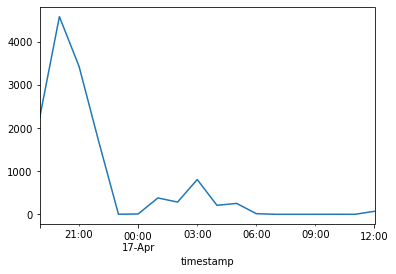

In [121]:
df.resample('H').request_method.count().plot()

Looks pretty normal - most folks access it early on, with some additionals later on.

##### TO examine - look at ip vs timestamp!

In [162]:
sns.lineplot(data = (df.resample('H').request_method.count()), hue = indexer)
plt.show()

ValueError: The following variable cannot be assigned with wide-form data: `hue`

### 3. Examine Dataframe with tail of request paths

In [124]:
df.request_path.value_counts().tail(50)

/api/v1/sales?page=134                     59
/api/v1/sales?page=172                     59
/api/v1/sales?page=181                     59
/api/v1/sales?page=180                     59
/api/v1/sales?page=179                     59
/api/v1/sales?page=178                     59
/api/v1/sales?page=177                     59
/api/v1/sales?page=176                     59
/api/v1/sales?page=175                     59
/api/v1/sales?page=174                     59
/api/v1/sales?page=173                     59
/api/v1/sales?page=171                     59
/api/v1/sales?page=170                     59
/api/v1/sales?page=169                     59
/api/v1/sales?page=168                     59
/api/v1/sales?page=166                     59
/api/v1/sales?page=165                     59
/api/v1/sales?page=164                     59
/api/v1/sales?page=163                     59
/api/v1/sales?page=162                     59
/api/v1/sales?page=161                     59
/api/v1/sales?page=137            

As we see, most of the request paths less than 56 counts are mistyped urls.

### 4. Examine all non 200 status codes

In [128]:
df[df.status_code != '200']

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1
2019-04-16 19:56:02,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1
2019-04-16 20:28:46,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:33:24,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:45:28,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0


IP = 97.105.19.58 is the main request ip, so these are probably just random flubs.

IP = 72.181.113.170 is the third most prominent IP, so these are also likely jsut flubs.

### 5. Sort by size to identify anything huge

In [147]:
df['size'].sort_values(ascending = False).head(25)

timestamp
2019-04-16 21:37:37    513736
2019-04-16 20:02:27    513736
2019-04-17 01:42:33    513736
2019-04-16 21:41:10    513736
2019-04-16 21:36:54    513736
2019-04-16 19:48:43    513736
2019-04-16 21:22:52    513736
2019-04-16 21:04:16    513736
2019-04-16 20:55:20    513736
2019-04-16 20:08:02    513736
2019-04-16 20:38:12    513736
2019-04-17 03:26:34    513736
2019-04-16 19:38:58    513736
2019-04-16 20:51:51    513736
2019-04-16 20:00:51    513736
2019-04-16 22:38:05    513736
2019-04-16 20:28:27    513736
2019-04-16 19:45:28    513736
2019-04-17 04:43:39    513736
2019-04-16 21:47:20    513736
2019-04-16 20:19:34    513736
2019-04-16 20:41:30    513736
2019-04-16 21:32:44    513736
2019-04-16 20:58:31    513736
2019-04-16 22:09:53    513736
Name: size, dtype: int64

In [148]:
df['size'].sort_values(ascending = False).tail(25)

timestamp
2019-04-16 20:34:11    42
2019-04-16 21:09:53    42
2019-04-16 21:48:21    42
2019-04-16 21:25:29    42
2019-04-16 21:25:08    42
2019-04-16 20:04:54    42
2019-04-16 19:56:07    42
2019-04-16 20:34:20    42
2019-04-16 21:25:24    42
2019-04-16 20:28:46     0
2019-04-16 20:45:17     0
2019-04-16 21:30:46     0
2019-04-17 03:42:44     0
2019-04-16 20:39:00     0
2019-04-16 19:56:02     0
2019-04-16 20:33:24     0
2019-04-16 20:45:28     0
2019-04-17 02:48:36     0
2019-04-16 20:38:55     0
2019-04-16 21:39:21     0
2019-04-16 21:00:35     0
2019-04-16 21:02:07     0
2019-04-16 20:38:13     0
2019-04-16 19:55:15     0
2019-04-16 22:21:38     0
Name: size, dtype: int64

Looks like no outliers on the high side.  The zeros on the low side are all the 499 errors.

### 6. Histogram of sizes

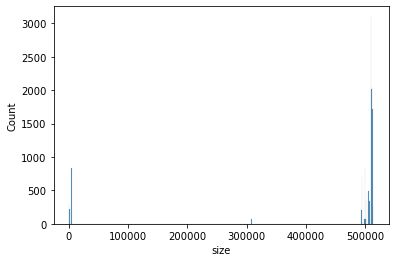

In [150]:
sns.histplot(data=df['size'])
plt.show()

In [152]:
df[df['size'] == 42]

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:52,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
2019-04-16 19:35:37,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
2019-04-16 19:35:38,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
2019-04-16 19:35:44,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
2019-04-16 19:36:54,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
...,...,...,...,...,...,...,...
2019-04-17 01:31:56,173.173.113.51,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
2019-04-17 02:06:38,68.201.219.223,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
2019-04-17 02:07:29,68.201.219.223,GET,/,HTTP/1.1,200,42,python-requests/2.21.0


In [155]:
df[df['size'] == 126]

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:52:25,97.105.19.58,GET,/api/v1,HTTP/1.1,200,126,python-requests/2.21.0


##### Next step - compare the sizes of common things to see if there are any outliers within the size groups.

### 7. Think more about user_agent

In [170]:
pd.set_option('display.max_rows',500)
df[~df.user_agent.isin(['python-requests/2.21.0','python-requests/2.20.1'])]

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
2019-04-16 19:38:16,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
2019-04-16 19:39:14,3.92.201.136,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
2019-04-16 19:40:32,3.88.129.158,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...
2019-04-16 19:40:33,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
2019-04-16 19:40:36,54.172.14.223,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...
2019-04-16 19:40:37,34.229.70.250,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
2019-04-16 19:44:04,97.105.19.58,GET,/api/v1/stores?page=0,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
